In [178]:
from qutip import *
import numpy as np
from numpy.polynomial.hermite import hermval
import math
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap

scale = 1.2
sizeOfFont = scale*15
fontProperties = {'family':'sans-serif','sans-serif':['Helvetica'],
     'size' : sizeOfFont}
rc('text', usetex=True)
rc('font',**fontProperties)
rc('text.latex', preamble=r'\usepackage{sansmathfonts}')
# Fix binomial code parameters
Nval = 4  
Kval = 4
muval = 0 

# Define max dimension of the Hilbert space
N = Kval*Nval +1 # +1 is required because there minimum of Kval*Nval nonzero Fock states plus vacuum

In [175]:
# Destruction operators in the tensor product space of the input
def a1(N):
    return composite(destroy(N),identity(N))

def a2(N): 
    return composite(identity(N),destroy(N))


# Ideal binomial codewords
def bincodeX(Nbin, Kbin, mu):
    """Ideal binomial codewords eigenstates for logical X. mu = 0 is the plus logical state."""
    return sum(np.sqrt(math.comb(Kbin, i)/2**Kbin) *((-1)**(i*mu)) * basis(N, i*Nbin) for i in range(Kbin+1))

def bincodeZ(Nbin, Kbin, mu):
    """Ideal binomial codeworde eigenstate for logical Z. mu = 0 is the plus logical state."""
    return sum(np.sqrt(math.comb(Kbin, (2*i+mu))/2**(Kbin-1)) * basis(N, (2*i+mu)*Nbin) for i in range(int(np.floor((Kbin-mu)/2))+1))

# Beamsplitter Matrix
# quantum Stokes, eqn 4.6:
def Lt(N):
    return 1/2*(a1(N).dag()*a1(N) + a2(N).dag()*a2(N))

def Lx(N):
    return 1/2*(a1(N).dag()*a2(N) + a2(N).dag()*a1(N))

def Ly(N):
    return 1j/2*(a2(N).dag()*a1(N) - a1(N).dag()*a2(N))

def Lz(N):
    return 1/2*(a1(N).dag()*a1(N) - a2(N).dag()*a2(N))

def Bmatrix(Φ,Θ,Ψ,Λ):
    """This is the classical matrix given in 4.4, mainly to confirm parameter choice"""
    a = np.exp(1j*Λ/2)
    b = np.array([[np.exp(1j*Ψ/2),0],[0,np.exp(-1j*Ψ/2)]])
    c = np.array([[np.cos(Θ/2),np.sin(Θ/2)],[-np.sin(Θ/2),np.cos(Θ/2)]])
    d = np.array([[np.exp(1j*Φ/2),0],[0,np.exp(-1j*Φ/2)]])
    return a * b @ c @ d

# Beamsplitter Unitary Operator
def B(Φ,Θ,Ψ,Λ):
    """Create the B operator given in 4.12"""
    B = (-1j*Φ*Lz(N)).expm() * (-1j*Θ*Ly(N)).expm() * (-1j*Ψ*Lx(N)).expm() * (-1j*Λ*Lt(N)).expm()
    return B

def createB(T):
    """Creates B unitary operator with transmittance T"""
     # Create a beamsplitter for the simulation
    Θ = 2*np.arccos(np.sqrt(T))
    return B(0,Θ,0,0).dag() # Compute the beamsplitter unitary

# pure vacuum loss and beamsplitter
def pureLossChannel(psi, Loss):
    """Density operator after pure vacuum loss channel"""
    bs = createB(1-Loss)
    state =composite(psi, fock(N, 0)) 
    state = bs*state
    return (state).ptrace([i for i in range(len(psi.dims[0]))])

def BeamsplitterLossMeasure(psi, T, eta, op):
    """Pure state mixes with vacuum at BS, undergoes (1-eta) loss, and a measurement op"""
    d1      = psi.dims[0]
    # Extend the Hilbert space with a vacuum mode
    state = composite(psi, fock(N, 0))
    d2      = state.dims[0]
    # First beamsplitter
    bs      = createB(T)
    state   = bs*state
    # Extend the Hilbert space with a vacuum mode
    state   = composite(state, fock(N,0))
    # Second beamsplitter to simulate loss
    bs2     = composite(identity(d1),createB(eta))
    state   = bs2*state
    state   = (state).ptrace([i for i in range(len(d2))])
    # Construct POVM set
    Pi      = composite(identity(d1), op)
    # tr(rho * rho)
    return (Pi*state*Pi.dag()).ptrace(range(len(d1)))

# k-Photon Subtraction
def kPS(psi, T, eta, k):
    """Density operator after "eta efficient" k-Photon Subtraction at a beamsplitter with transmittance T"""
    # Construct POVM set
    # Pi = composite(identity(d1), fock_dm(N, k))
    # povm = [Pi, composite(identity(d1), identity(N)) - Pi]
    # return (qutip.measurement.measurement_statistics_povm(state, povm )[0][0]).ptrace(0)
    return BeamsplitterLossMeasure(psi, T, eta, fock_dm(N, k))

In [4]:
# DYNE MEASUREMENTS
def psi_n(n,x):
    """Evalutes the <x|n> wavefunction at x
    https://en.wikipedia.org/wiki/Quantum_harmonic_oscillator
    """
    c       = [int(i == n) for i in range(N)]
    Hermite = hermval(x,c)
    coef    = 1/np.sqrt((2**n)*(math.factorial(n)))
    Gauss   = np.exp(-(x**2)/2)
    const   = (np.pi)**(-1/4)
    return coef*const*Gauss*Hermite

def psi_x(x):
    """State |x> = \sum_n{|n><n|x>} constructed in the Fock basis expansion
    alternate: |x> := \hat{O}|0>
    https://physics.stackexchange.com/questions/292899/creating-a-qm-state-of-definite-position-in-fock-space
    """
    return sum( [ psi_n(n,x)*fock(N,n) for n in range(N) ] )
    # a = destroy(N)
    # op = -(1/2) * ( a.dag() - np.sqrt(2)*x )**2  
    # return ( np.exp((x**2)/2) / (np.pi)**(1/4) ) * op.expm()*fock(N, 0)

def Pi_x_density(x):
    """von Neumann projector Pi_x :=  |x> <x|"""
    return ket2dm(psi_x(x))
    
def homodyne(center, Delta, points):
    """Kraus operator that projects the state onto the sum of |x_i><x_i| projectors in a Delta range around center"""
    dx      = Delta/(points-1)
    return dx * sum( [ Pi_x_density(x) for x in np.linspace(center-Delta/2,center+Delta/2, points) ] )


def HOM(psi, T, eta, center, Delta, points):
    """Perform homodyne measurement with T:1-T beasmplitter.
      psi is ket."""
    return BeamsplitterLossMeasure(psi, T, eta, homodyne(center, Delta, points))
def pts(Delta, dx):
    return int(Delta/dx +1)

def fidelityZPSHOM(psi, T, eta, center, Delta, points):
    """Fidelity between ideal ZPS and HOM heralded output"""
    zps = kPS(psi, T, 1, 0).unit()
    hom = HOM(psi, T, eta, center, Delta, points).unit()
    return fidelity(zps,hom)

def fidelityZPSTHR(psi, T, eta):
    """Fidelity between ideal ZPS and HOM heralded output"""
    zps = kPS(psi, T, 1, 0).unit()
    thr = kPS(psi, T, eta, 0).unit()
    return fidelity(zps,thr)

def DeltaHS(psi_0, psi_1, psi_2):
    return 0.5*qutip.metrics.hilbert_dist(psi_1, psi_0) - 0.5*qutip.metrics.hilbert_dist(psi_2, psi_0) 

def DeltaPS(psi_1, psi_2):
    return psi_1.tr() - psi_2.tr()

def DeltaF(psi_0, psi_1, psi_2):
    return fidelity(psi_0, psi_1) - fidelity(psi_0, psi_2)

Logical 0 state

<Figure size 640x480 with 0 Axes>

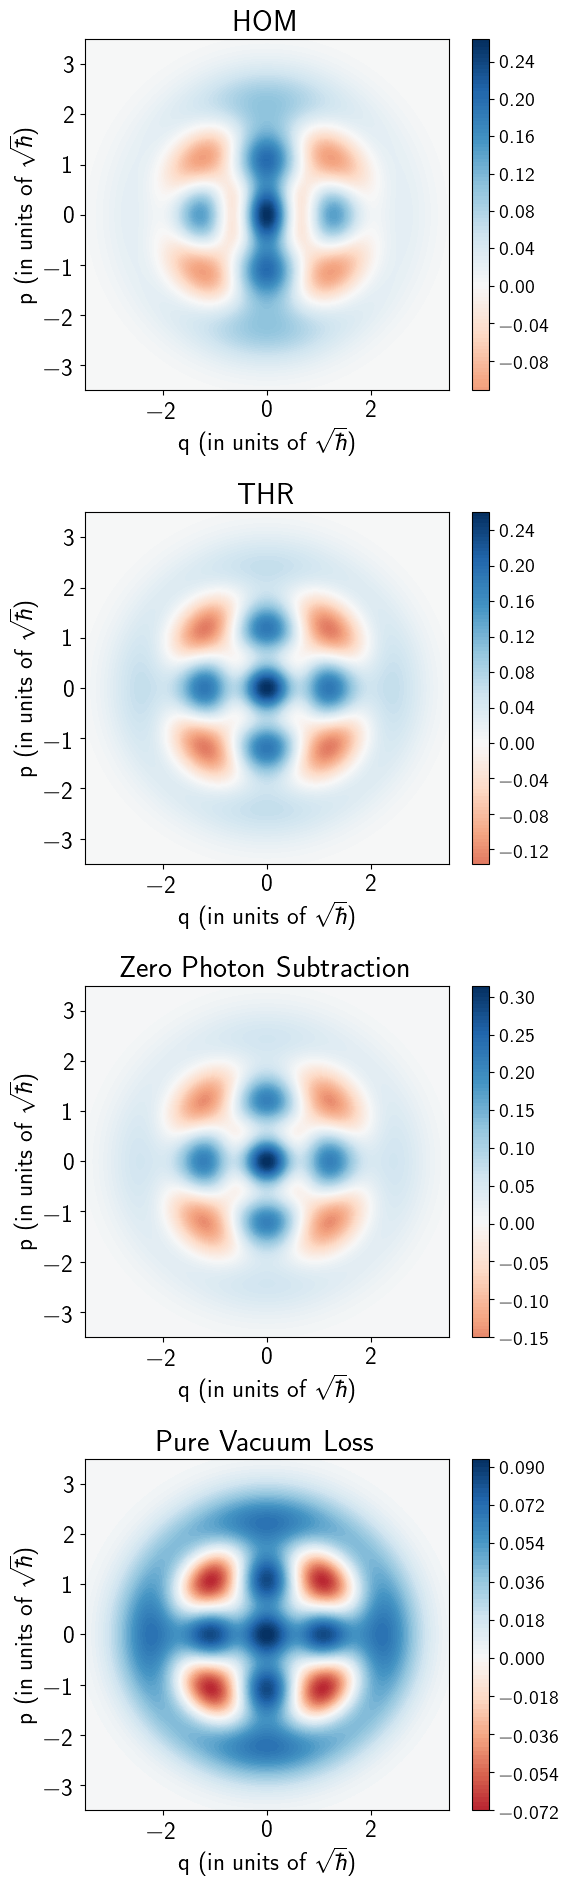

In [ ]:
# Results
T       = 0.75
eta     = 0.85
center  = 0
Delta   = 0.1
points  = pts(Delta, 1e-3)

psi1    = bincodeZ( Nval, Kval , 0)
outZPS  = kPS(psi1, T, 1,   0).unit()
outTHR  = kPS(psi1, T, eta, 0).unit()
outHOM  = HOM(psi1, T, eta, center, Delta, points).unit()
outLOSS = pureLossChannel(psi1, 1-T).unit()


#Plotting
limi    = 3.5
rang    = 100 
xvec    = np.linspace(-limi, limi, rang)

W       = [wigner(outHOM, xvec, xvec), wigner(outTHR, xvec, xvec), wigner(outZPS, xvec, xvec), wigner(outLOSS, xvec, xvec)]

nrm     = [mpl.colors.Normalize(-W[i].max(), W[i].max()) for i in range(len(W))]

plt.figure(dpi=100)

cols    = 1
rows    = len(W)
fig, axes = plt.subplots(rows, cols, figsize=(scale*5*cols,scale*4*rows))

plots   = [axes[i].contourf(xvec, xvec, W[i], 100, cmap=cm.RdBu, norm=nrm[i]) for i in range(len(W))]

axes[0].set(title = f"HOM",  xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[1].set(title = f"THR",  xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[2].set(title = f"Zero Photon Subtraction",         xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[3].set(title = f"Pure Vacuum Loss",                xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )

cb      = [fig.colorbar(plots[i], ax=axes[i]) for i in range(len(W))]

[cb[i].ax.tick_params(labelsize = scale*12) for i in range(len(W))]

fig.tight_layout()

plt.show()

Logical plus state

<Figure size 640x480 with 0 Axes>

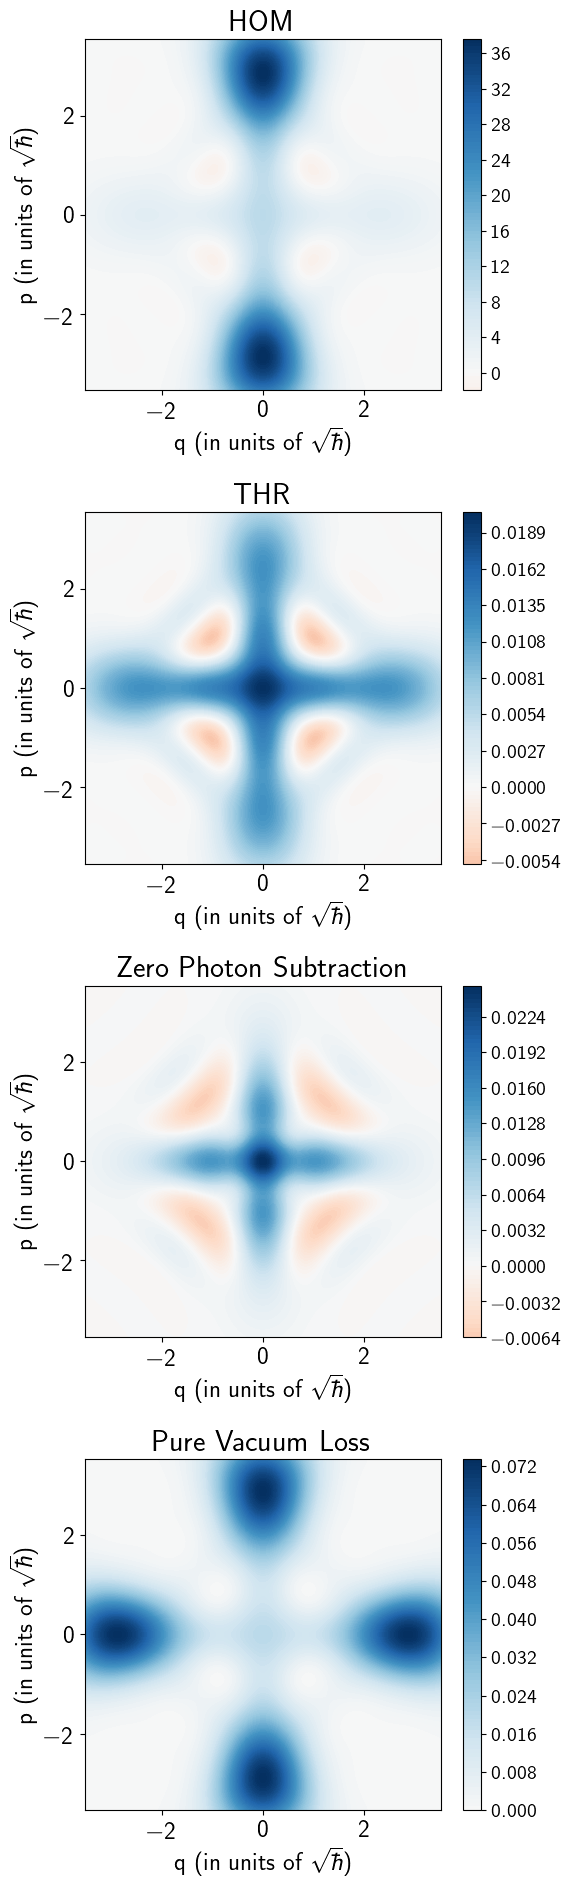

In [ ]:
# Results
T       = 0.5
eta     = 0.5
center  = 0
Delta   = 2
points  = 50

outZPS  = kPS(psi1, T, 1,   0).unit()
outTHR  = kPS(psi1, T, eta, 0).unit()
outHOM  = HOM(psi1, T, eta, center, Delta, points).unit()
outLOSS = pureLossChannel(psi1, 1-T).unit()


#Plotting
limi    = 3.5
rang    = 100 
xvec    = np.linspace(-limi, limi, rang)

W       = [wigner(outHOM, xvec, xvec), wigner(outTHR, xvec, xvec), wigner(outZPS, xvec, xvec), wigner(outLOSS, xvec, xvec)]

nrm     = [mpl.colors.Normalize(-W[i].max(), W[i].max()) for i in range(len(W))]

plt.figure(dpi=100)

cols    = 1
rows    = len(W)
fig, axes = plt.subplots(rows, cols, figsize=(scale*5*cols,scale*4*rows))

plots   = [axes[i].contourf(xvec, xvec, W[i], 100, cmap=cm.RdBu, norm=nrm[i]) for i in range(len(W))]

axes[0].set(title = f"HOM",  xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[1].set(title = f"THR",  xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[2].set(title = f"Zero Photon Subtraction",         xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )
axes[3].set(title = f"Pure Vacuum Loss",                xlabel = f'q (in units of  $\sqrt\hbar$)',  ylabel = f'p (in units of  $\sqrt\hbar$)' )

cb      = [fig.colorbar(plots[i], ax=axes[i]) for i in range(len(W))]

[cb[i].ax.tick_params(labelsize = scale*12) for i in range(len(W))]

fig.tight_layout()

plt.show()

Logical 0 state

In [182]:
# Parameters
T       = 0.5 # fix
etaH    = 1 # fix
dx      = 1e-1
psi     = bincodeZ(Nval, Kval, 0) 

# Create matrices for plotting
zps     = kPS(psi, T, 1,   0).unit()

Deltavec= np.linspace(dx, 5, 60)
etaTvec = np.linspace(0, 1, 60)
Psiun   = [ [ [HOM(psi, T, etaH, center, i, pts(i,dx)), kPS(psi, T, j, 0)] for i in Deltavec ] for j in etaTvec ]

<Figure size 640x480 with 0 Axes>

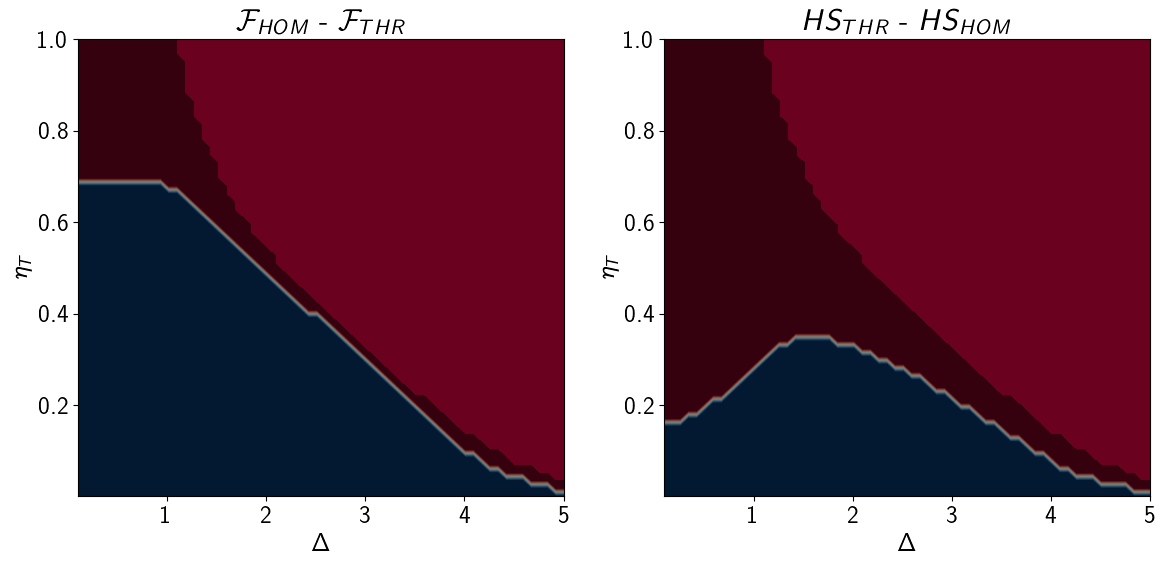

In [ ]:
deltaF  = [ [ DeltaF(zps, Psiun[j][i][0].unit(), Psiun[j][i][1].unit()) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]
deltaHS = [ [ DeltaHS(zps, Psiun[j][i][1].unit(), Psiun[j][i][0].unit()) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]
deltaPS = [ [ DeltaPS( Psiun[j][i][0], Psiun[j][i][1] ) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]

def nrmAmount(mat):
    return max(np.max(mat), np.abs(np.min(mat)))

def nrm(mat):
    return mpl.colors.Normalize(-nrmAmount(mat), nrmAmount(mat) )

# Custom color map for the improvement in success probablity alpha plot overlay
cmap = plt.cm.Greys
my_cmap = cmap(np.arange(cmap.N))
# Set all alpha values to 0
my_cmap[:, -1] = 0*np.linspace(0, 1, cmap.N)
# Increase opacity for the final two values of alpha in the colorbar
my_cmap[-2,3] = 0.5
my_cmap[-1,3] = 0.5
my_cmap = ListedColormap(my_cmap)

plt.figure(dpi=100)
# Subplots
cols    = 2
rows    = 1

fig, axes   = plt.subplots(rows, cols, figsize=(scale*5*cols,scale*5*rows))

# Plot 1 - difference in Fidelities to ideal ZPS
normvalF   = nrm(2*np.heaviside(deltaF, 0.5)-1)
matF       = 2*np.heaviside(deltaF, 0.5)-1

# Plot 2 - difference in the Hilbert-Schmidt distances
normvalHS   = nrm(2*np.heaviside(deltaHS, 0.5)-1)
matHS       = 2*np.heaviside(deltaHS, 0.5)-1

# Overlay - difference in the success probabilities
normvalPS   = mpl.colors.Normalize(0, nrmAmount(np.heaviside(deltaPS,0.5)) )
matPS       = np.heaviside(deltaPS,0.5)

# Make figure
plot1       = axes[0].contourf(Deltavec, etaTvec,  matF, 100, cmap=cm.RdBu, norm=normvalF, zorder = 0)
plot2       = axes[1].contourf(Deltavec, etaTvec,  matHS, 100, cmap=cm.RdBu, norm=normvalHS, zorder = 0) 
axes[0].contourf(Deltavec, etaTvec,  1-matPS, 100, cmap=my_cmap, norm=normvalPS, zorder = 1) 
axes[1].contourf(Deltavec, etaTvec,  1-matPS, 100, cmap=my_cmap, norm=normvalPS, zorder = 1) 
axes[0].set(title = f"$\mathcal{{F}}_{{HOM}}$ - $\mathcal{{F}}_{{THR}}$",  xlabel = f'$\Delta$',  ylabel = f'$\eta_T$' )
axes[1].set(title = f"$HS_{{THR}}$ - $HS_{{HOM}}$",  xlabel = f'$\Delta$',  ylabel = f'$\eta_T$' )

fig.tight_layout()

plt.show()

Logical plus state

In [174]:
bs

Quantum object: dims = [[7, 7], [7, 7]], shape = (49, 49), type = oper, isherm = False
Qobj data =
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.70710678 0.         ... 0.         0.         0.        ]
 [0.         0.         0.5        ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99008118 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]

In [172]:
d1      = psi.dims[0]
# Extend the Hilbert space with a vacuum mode
state = composite(psi, fock(N, 0))
d2      = state.dims[0]
# First beamsplitter
bs      = createB(T)
state   = bs*state

TypeError: Incompatible Qobj shapes

In [171]:
# Parameters
T       = 0.5 # fix
etaH    = 1 # fix
dx      = 1e-1
psi     = bincodeX(Nval, Kval, 0) 

# Create matrices for plotting
zps     = kPS(psi, T, 1,   0).unit()

Deltavec= np.linspace(dx, 2.5, 30)
etaTvec = np.linspace(0.1, 0.9, 30)
Psiun   = [ [[HOM(psi, T, etaH, center, i, pts(i,dx)), kPS(psi, T, j, 0)] for i in Deltavec] for j in etaTvec ]

TypeError: Incompatible Qobj shapes

<Figure size 640x480 with 0 Axes>

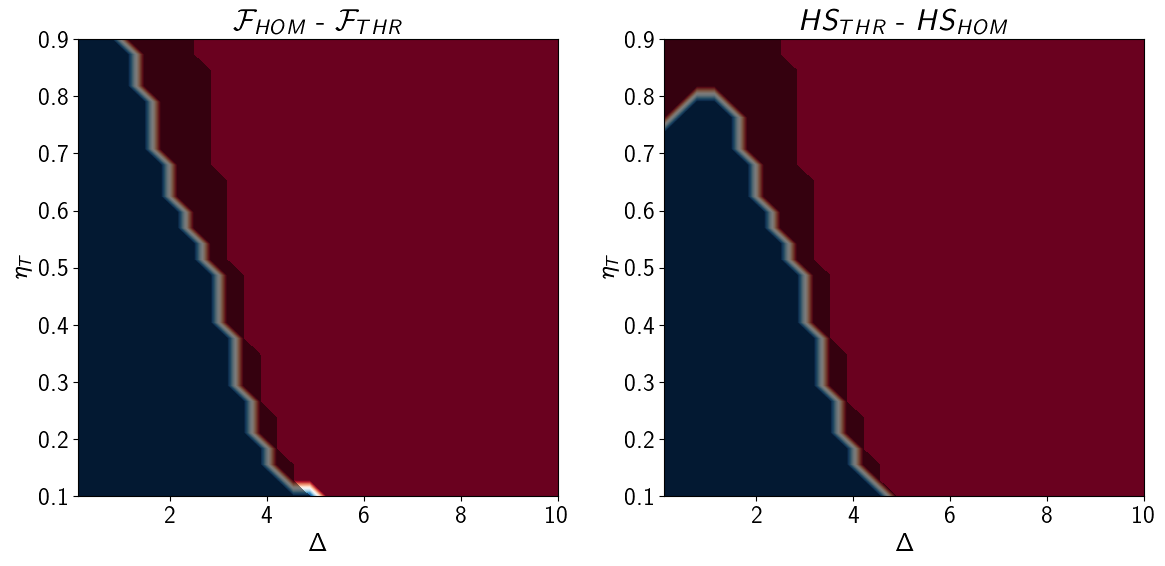

In [159]:
deltaF  = [ [ DeltaF(zps, Psiun[j][i][0].unit(), Psiun[j][i][1].unit()) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]
deltaHS = [ [ DeltaHS(zps, Psiun[j][i][1].unit(), Psiun[j][i][0].unit()) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]
deltaPS = [ [ DeltaPS( Psiun[j][i][0], Psiun[j][i][1] ) for i  in range(len(Deltavec))] for j in range(len(etaTvec))]

def nrmAmount(mat):
    return max(np.max(mat), np.abs(np.min(mat)))

def nrm(mat):
    return mpl.colors.Normalize(-nrmAmount(mat), nrmAmount(mat) )

# Custom color map for the improvement in success probablity alpha plot overlay
cmap = plt.cm.Greys
my_cmap = cmap(np.arange(cmap.N))
# Set all alpha values to 0
my_cmap[:, -1] = 0*np.linspace(0, 1, cmap.N)
# Increase opacity for the final two values of alpha in the colorbar
my_cmap[-2,3] = 0.5
my_cmap[-1,3] = 0.5
my_cmap = ListedColormap(my_cmap)

plt.figure(dpi=100)
# Subplots
cols    = 2
rows    = 1

fig, axes   = plt.subplots(rows, cols, figsize=(scale*5*cols,scale*5*rows))

# Plot 1 - difference in Fidelities to ideal ZPS
normvalF   = nrm(2*np.heaviside(deltaF, 0.5)-1)
matF       = 2*np.heaviside(deltaF, 0.5)-1

# Plot 2 - difference in the Hilbert-Schmidt distances
normvalHS   = nrm(2*np.heaviside(deltaHS, 0.5)-1)
matHS       = 2*np.heaviside(deltaHS, 0.5)-1

# Overlay - difference in the success probabilities
normvalPS   = mpl.colors.Normalize(0, nrmAmount(np.heaviside(deltaPS,0.5)) )
matPS       = np.heaviside(deltaPS,0.5)

# Make figure
plot1       = axes[0].contourf(Deltavec, etaTvec,  matF, 100, cmap=cm.RdBu, norm=normvalF, zorder = 0)
plot2       = axes[1].contourf(Deltavec, etaTvec,  matHS, 100, cmap=cm.RdBu, norm=normvalHS, zorder = 0) 
axes[0].contourf(Deltavec, etaTvec,  1-matPS, 100, cmap=my_cmap, norm=normvalPS, zorder = 1) 
axes[1].contourf(Deltavec, etaTvec,  1-matPS, 100, cmap=my_cmap, norm=normvalPS, zorder = 1) 
axes[0].set(title = f"$\mathcal{{F}}_{{HOM}}$ - $\mathcal{{F}}_{{THR}}$",  xlabel = f'$\Delta$',  ylabel = f'$\eta_T$' )
axes[1].set(title = f"$HS_{{THR}}$ - $HS_{{HOM}}$",  xlabel = f'$\Delta$',  ylabel = f'$\eta_T$' )



fig.tight_layout()

plt.show()

Fidelity seems to have the same behavior as the HS distance which is unexpected. 
Consider simple example: state has minimum HSD (=0) from itself but has maximum Fidelity (=1) with itself.

(1 - Fidelity) and HSD are two different metrics. 

Question: Which one is a better one in terms of closeness between two states, 'rho' and 'sigma'?

Fidelity is better because the HS distance is large due to compressing of wigner in one direction. That is ok as long as we don't loose any negativee regions.

Moreover, whether we see a 'favourable' region or not in the plot where both Fidelity and Success probability is higher, depends on the choice of bincode's (N ,K) values. For (2, 3) there doesn't seem to be any region upto Delta = 2.5, at the least. 